# ΕΠΕΞΕΡΓΑΣΙΑ ΦΥΣΙΚΗΣ ΓΛΩΣΣΑΣ - Εργασία 2
## B. Traditional Text Classification
**Μάθημα:**  Επεξεργασία Φυσικής Γλώσσας 

**Συγγραφέας:** Ιωάννης Kουτσούκης 

**Εκδόσεις:** 2025-04-14 | v.0.0.1

In [51]:
# Εγκατάσταση datasets αν δεν υπάρχει
%pip install datasets wordcloud --quiet

Note: you may need to restart the kernel to use updated packages.


In [52]:
from datasets import load_dataset
import pandas as pd

# Φόρτωση AG News dataset
dataset = load_dataset("ag_news")

# Μετατροπή σε DataFrame
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])


In [53]:
# Επισκόπηση δεδομένων
print('------------------------------------------------------------------')
print(df_train.head())
print('------------------------------------------------------------------')
print(df_train['label'].value_counts())  # 0=World, 1=Sports, 2=Business, 3=Sci/Tech
print('--------------------------------------------')
print(dataset['train'].features['label'].names)
print('------------------------------------------------------------------')
print(dataset['train'].column_names)
print('------------------------------------------------------------------')
print(f"Train size: {len(df_train)}")
print('------------------------------------------------------------------')
print(f"Test size: {len(df_test)}")

------------------------------------------------------------------
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2
------------------------------------------------------------------
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64
--------------------------------------------
['World', 'Sports', 'Business', 'Sci/Tech']
------------------------------------------------------------------
['text', 'label']
------------------------------------------------------------------
Train size: 120000
------------------------------------------------------------------
Test size: 7600


In [54]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Απλά lowercase για κανονικοποίηση
X_train = df_train['text'].str.lower()
X_test = df_test['text'].str.lower()

y_train = df_train['label']
y_test = df_test['label']


# Επισκόπηση δεδομένων

label_names = dataset['train'].features['label'].names

for i in range(3):
    print(f"Sample {i+1}")
    print("Text:", X_train.iloc[i])
    print("Label:", label_names[y_train.iloc[i]])
    print("-" * 50)

Sample 1
Text: wall st. bears claw back into the black (reuters) reuters - short-sellers, wall street's dwindling\band of ultra-cynics, are seeing green again.
Label: Business
--------------------------------------------------
Sample 2
Text: carlyle looks toward commercial aerospace (reuters) reuters - private investment firm carlyle group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Label: Business
--------------------------------------------------
Sample 3
Text: oil and economy cloud stocks' outlook (reuters) reuters - soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Label: Business
--------------------------------------------------


### Ερώτημα 1 – Υλοποίηση Παραδοσιακών Ταξινομητών

Σε αυτό το ερώτημα υλοποιούνται τέσσερις διαφορετικές προσεγγίσεις παραδοσιακής ταξινόμησης κειμένου με τη χρήση της βιβλιοθήκης `scikit-learn`. Συγκεκριμένα, εξετάζουμε δύο κατηγορίες ταξινομητών (Multinomial Naive Bayes και SVM με γραμμικό kernel) σε συνδυασμό με δύο τύπους αναπαράστασης χαρακτηριστικών (TF-IDF word 1-grams και TF-IDF character 3-grams).  



In [55]:
#Ορισμος συναρτησης benchmarking
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from time import time

def evaluate_model(ngram_type='word', ngram_range=(1,1), model_type='nb'):
    analyzer = 'char' if ngram_type == 'char' else 'word'
    vectorizer = TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range)
    
    if model_type == 'nb':
        model = MultinomialNB()
    elif model_type == 'svm':
        model = LinearSVC(C=1)

    pipeline = make_pipeline(vectorizer, model)

    start = time()
    pipeline.fit(X_train, y_train)
    duration = time() - start

    predictions = pipeline.predict(X_test)
    acc = accuracy_score(y_test, predictions)

    dim = len(pipeline.named_steps['tfidfvectorizer'].get_feature_names_out())

    return acc, dim, round(duration, 2), predictions


In [56]:
# Συγκεντρωτική εκτέλεση για τα 4 μοντέλα της εκφώνησης

results = []

# 1. NB - word unigrams
acc, dim, time_sec, _ = evaluate_model(ngram_type='word', ngram_range=(1,1), model_type='nb')
results.append(('NB (word unigrams)', acc, dim, time_sec))

# 2. NB - char trigrams
acc, dim, time_sec, _ = evaluate_model(ngram_type='char', ngram_range=(3,3), model_type='nb')
results.append(('NB (char trigrams)', acc, dim, time_sec))

# 3. SVM - word unigrams
acc, dim, time_sec, _ = evaluate_model(ngram_type='word', ngram_range=(1,1), model_type='svm')
results.append(('SVM (word unigrams)', acc, dim, time_sec))

# 4. SVM - char trigrams
acc, dim, time_sec, _ = evaluate_model(ngram_type='char', ngram_range=(3,3), model_type='svm')
results.append(('SVM (char trigrams)', acc, dim, time_sec))


### Ερώτημα 2 – Σύγκριση Αποδόσεων Μοντέλων

Στο ερώτημα αυτό πραγματοποιείται σύγκριση των τεσσάρων μοντέλων που υλοποιήθηκαν προηγουμένως, με βάση τρία βασικά κριτήρια: ακρίβεια (accuracy), διαστατικότητα (dimensionality) και χρονικό κόστος εκπαίδευσης (training time).  

Τα αποτελέσματα συγκεντρώνονται σε πίνακα και ακολουθούν συνοπτικά συμπεράσματα που προκύπτουν από τη σύγκριση των επιδόσεων.


In [57]:
import pandas as pd

# Δημιουργούμε ξανά το DataFrame με reset του index
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Dimensionality", "Time Cost (sec)"]).reset_index(drop=True)

# Δημιουργία transposed πίνακα
df_results_named = pd.DataFrame({
    "NB (word 1-grams)":    df_results.loc[0, ["Accuracy", "Dimensionality", "Time Cost (sec)"]],
    "NB (char 3-grams)":    df_results.loc[1, ["Accuracy", "Dimensionality", "Time Cost (sec)"]],
    "SVM (word 1-grams)":   df_results.loc[2, ["Accuracy", "Dimensionality", "Time Cost (sec)"]],
    "SVM (char 3-grams)":   df_results.loc[3, ["Accuracy", "Dimensionality", "Time Cost (sec)"]],
})


# Formatting: accuracy 2 dec, dim with comma, time 2 dec
df_results_named.loc["Accuracy"] = df_results_named.loc["Accuracy"].astype(float).map("{:.2f}".format)
df_results_named.loc["Dimensionality"] = df_results_named.loc["Dimensionality"].astype(int).map("{:,}".format)
df_results_named.loc["Time Cost (sec)"] = df_results_named.loc["Time Cost (sec)"].astype(float).map("{:.2f}".format)


# Προβολή πίνακα
df_results_named


,NB (word 1-grams),NB (char 3-grams),SVM (word 1-grams),SVM (char 3-grams)
Accuracy,0.90,0.87,0.92,0.91
Dimensionality,"65,006","31,072","65,006","31,072"
Time Cost (sec),1.22,5.16,6.90,20.96


### Ερώτημα 2 – Συμπεράσματα Αποτελεσμάτων

Από τη σύγκριση των τεσσάρων διαφορετικών μοντέλων προκύπτουν τα εξής βασικά συμπεράσματα:

- Η **ακρίβεια (accuracy)** κυμαίνεται σε υψηλά επίπεδα για όλες τις μεθόδους, με ελαφρώς καλύτερη απόδοση των **SVM μοντέλων** (έως και 92%). Η διαφορά, ωστόσο, είναι μικρή.
- Οι **Naive Bayes ταξινομητές** έχουν σημαντικό πλεονέκτημα στον **χρόνο εκπαίδευσης**, καθώς είναι εως και **10 φορές ταχύτεροι** από τους αντίστοιχους SVM.
- Η **διάσταση του χώρου χαρακτηριστικών (dimensionality)** εξαρτάται αποκλειστικά από το είδος του n-gram:
  - Τα **character 3-grams** οδηγούν σε περίπου **50% λιγότερες διαστάσεις** σε σχέση με τα word 1-grams.
  - Δεν παρατηρείται διαφορά στις διαστάσεις μεταξύ NB και SVM όταν χρησιμοποιούν τον ίδιο vectorizer.
- Αν χρειαζόταν να επιλεγεί ένα μοντέλο με γνώμονα τη συνολική απόδοση (ισορροπία μεταξύ ταχύτητας και ακρίβειας), τότε το **Naive Bayes με word 1-grams** φαίνεται να προσφέρει το **καλύτερο "value for performance"**.
- Εάν, ωστόσο, η **μέγιστη ακρίβεια ήταν κρίσιμη**, τότε προτείνεται η χρήση του **SVM**, με κόστος την αυξημένη υπολογιστική απαίτηση.



### Ερώτημα 3 – Ανάλυση Λανθασμένων Προβλέψεων

Στο τρίτο ερώτημα επικεντρωθήκαμε στις περιπτώσεις όπου **και τα τέσσερα μοντέλα** (Naive Bayes και SVM με word unigrams και char trigrams) **απέτυχαν να προβλέψουν σωστά** την κατηγορία κειμένου.

Για να εντοπίσουμε αυτά τα κοινά λάθη:
- Συγκρίναμε τις προβλέψεις κάθε μοντέλου με τις πραγματικές κατηγορίες του test set.
- Φιλτράραμε τα κείμενα όπου όλα τα μοντέλα έκαναν λάθος.
- Χαρτογραφήσαμε τις εσφαλμένες κατηγοριοποιήσεις, εμφανίζοντας τόσο το πραγματικό label όσο και τις προβλέψεις των μοντέλων.
- Οπτικοποιήσαμε το περιεχόμενο των κειμένων με **Word Cloud**, ώστε να κατανοήσουμε ποιο λεξιλόγιο επανεμφανίζεται στις προβληματικές περιπτώσεις.

Η ανάλυση που ακολούθησε οδήγησε σε σημαντικά συμπεράσματα, τα οποία παρουσιάζονται παρακάτω.


In [58]:
# Προβλέψεις για όλα τα μοντέλα
_, _, _, pred_nb_word = evaluate_model('word', (1,1), 'nb')
_, _, _, pred_nb_char = evaluate_model('char', (3,3), 'nb')
_, _, _, pred_svm_word = evaluate_model('word', (1,1), 'svm')
_, _, _, pred_svm_char = evaluate_model('char', (3,3), 'svm')


In [59]:
import numpy as np

# Μετατροπή σε πίνακες για vectorized σύγκριση
y_true = y_test.to_numpy()

# Μάσκες λαθών για κάθε μοντέλο
err_nb_word = pred_nb_word != y_true
err_nb_char = pred_nb_char != y_true
err_svm_word = pred_svm_word != y_true
err_svm_char = pred_svm_char != y_true

# Κοινά λάθη: όπου όλα τα μοντέλα έκαναν λάθος
all_wrong_mask = err_nb_word & err_nb_char & err_svm_word & err_svm_char


In [62]:
# Φιλτράρουμε τα κοινά λάθη
df_errors = df_test[all_wrong_mask].copy()

# Προσθέτουμε το σωστό label (όνομα)
df_errors['true_category'] = df_errors['label'].apply(lambda x: label_names[x])

# Προσθέτουμε τις προβλέψεις από τα μοντέλα (ως αριθμούς → ονόματα)
df_errors['nb_word'] = pred_nb_word[all_wrong_mask]
df_errors['nb_char'] = pred_nb_char[all_wrong_mask]
df_errors['svm_word'] = pred_svm_word[all_wrong_mask]
df_errors['svm_char'] = pred_svm_char[all_wrong_mask]

# Μετατρέπουμε τις προβλέψεις σε labels
df_errors['nb_word'] = df_errors['nb_word'].apply(lambda x: label_names[x])
df_errors['nb_char'] = df_errors['nb_char'].apply(lambda x: label_names[x])
df_errors['svm_word'] = df_errors['svm_word'].apply(lambda x: label_names[x])
df_errors['svm_char'] = df_errors['svm_char'].apply(lambda x: label_names[x])

df_errors[['text', 'true_category', 'nb_word', 'nb_char', 'svm_word', 'svm_char']] #.head()


,text,true_category,nb_word,nb_char,svm_word,svm_char
24,Rivals Try to Turn Tables on Charles Schwab By...,Sci/Tech,Business,Business,Business,Business
56,India's Tata expands regional footprint via Na...,World,Business,Business,Business,Business
79,Live: Olympics day four Richard Faulds and Ste...,World,Sports,Sports,Sports,Sports
83,Intel to delay product aimed for high-definiti...,Business,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech
106,Stocks Climb on Drop in Consumer Prices NEW YO...,World,Business,Business,Business,Business
...,...,...,...,...,...,...
7413,Bush Pledges Strong-Dollar Policy President Bu...,Business,World,World,World,World
7470,Broadband charges set to tumble The cost of br...,Business,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech
7492,FCC Mulls Airborne Mobile Phone Use Although t...,Business,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech
7539,Mars water tops science honours The discovery ...,World,Sci/Tech,Sci/Tech,Sci/Tech,Sci/Tech


Συνολικά λάθη από όλα τα μοντέλα: 341

Κατανομή λαθών ανά κατηγορία:
true_category
Business    135
World       112
Sci/Tech     85
Sports        9
Name: count, dtype: int64


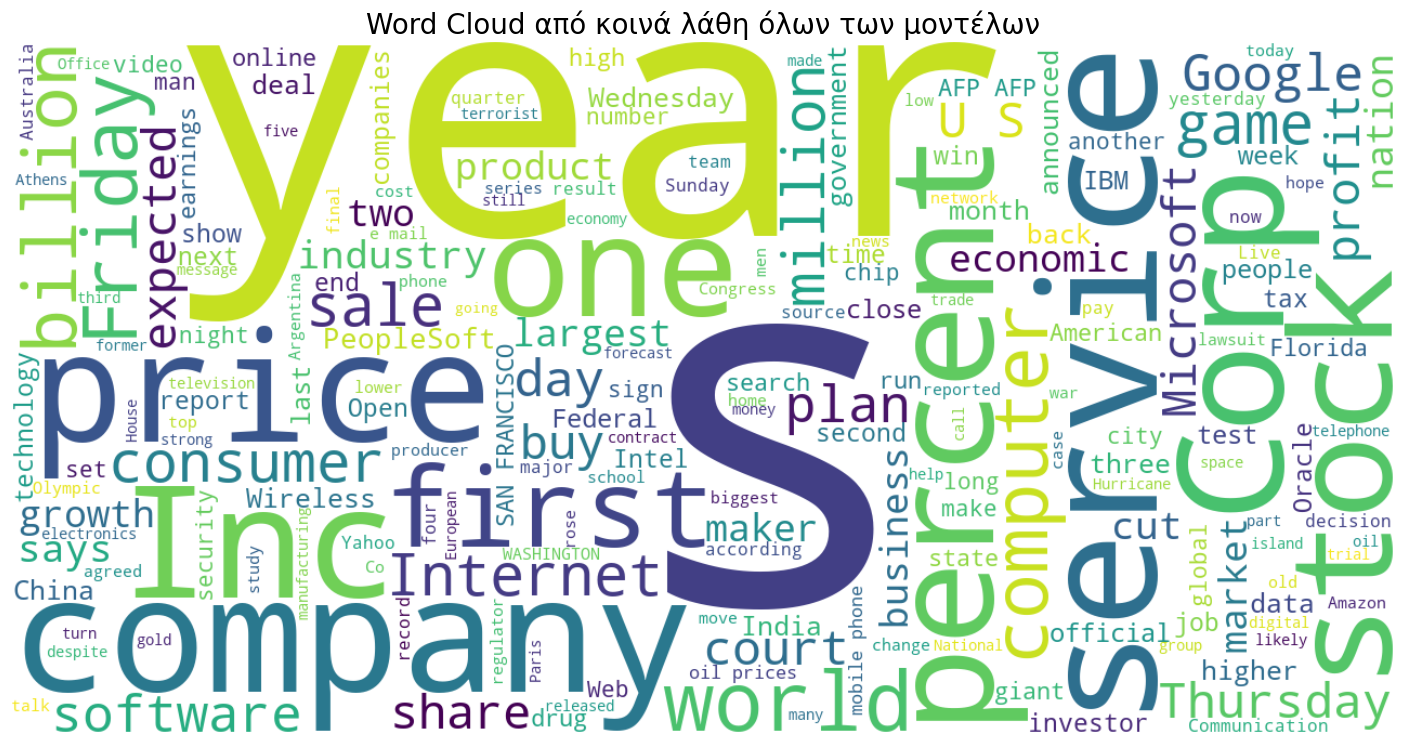

In [64]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Συνολικά Λάθη
print(f"Συνολικά λάθη από όλα τα μοντέλα: {len(df_errors)}")

# Ανά κατηγορία
error_counts = df_errors['true_category'].value_counts()
print("\nΚατανομή λαθών ανά κατηγορία:")
print(error_counts)

# Stopwords + φίλτρο μικρών λέξεων
text_data = ' '.join(df_errors['text'])
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'say', 'will', 'quot', 'may', 'monday', 'tuesday', 'reuters', 'ap', 'new', 'york'])

text_data_clean = ' '.join([w for w in text_data.split() if len(w) > 2])

# Δημιουργία word cloud
wc = WordCloud(
    width=1280, height=640,
    background_color='white',
    max_words=200,
    colormap='viridis',
    stopwords=custom_stopwords
).generate(text_data_clean)

# Προβολή
plt.figure(figsize=(18, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud από κοινά λάθη όλων των μοντέλων", fontsize=20)
plt.show()

### 🔍 Συμπεράσματα – Ερώτημα 3

Στο τρίτο ερώτημα μελετήσαμε τις περιπτώσεις του test set όπου **όλα τα μοντέλα απέτυχαν να προβλέψουν σωστά** την κατηγορία. Η ανάλυση των κοινών αυτών λαθών μας οδήγησε στα εξής βασικά συμπεράσματα:

- **Οι περισσότερες εσφαλμένες προβλέψεις** παρατηρούνται στις κατηγορίες **"World"** και **"Business"**, γεγονός που πιθανώς οφείλεται:
  - σε **ασάφειες και θεματικές επικαλύψεις**
  - στην **πολυσημία** ορισμένων λέξεων και όρων
  - στο ότι πολλές ειδήσεις αφορούν και τα δύο επίπεδα (π.χ. διεθνής επιχειρηματική δραστηριότητα)

- Αντίθετα, **η κατηγορία "Sports" παρουσιάζει ελάχιστα λάθη**, γεγονός που υποδηλώνει ότι τα αθλητικά κείμενα είναι πιο **σαφώς διακριτά** ως προς τη γλώσσα και το περιεχόμενό τους (ορολογία, ομάδες, αθλήματα κ.λπ.).

- Το **Word Cloud** των κοινών λαθών αποκαλύπτει λέξεις όπως:  
  **`company`, `year`, `service`, `corp`, `price`, `percent`**, οι οποίες εμφανίζονται συχνά αλλά δεν είναι επαρκείς για ακριβή ταξινόμηση, καθώς χρησιμοποιούνται και σε **πολλαπλά συμφραζόμενα**.

- Παρατηρείται ότι **όλα τα μοντέλα κάνουν το ίδιο λάθος στις ίδιες περιπτώσεις**, επιλέγοντας την ίδια (λανθασμένη) κατηγορία.  
  Αυτό δείχνει ότι **μία ensemble προσέγγιση (όπως majority vote)** δεν θα βελτίωνε την ακρίβεια σε αυτές τις περιπτώσεις, αφού **υπάρχει απόλυτη συμφωνία στο λάθος**.
